# Forward Stagewise GLM Debugging Notebook

Test out basic least squares regression with ForwardStagewiseGLM class implementation.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.base import clone as clone_model

from genestboost import ForwardStagewiseGLM
from genestboost.link_functions import LogitLink, CLogLogLink
from genestboost.loss_functions import LogLoss

%matplotlib inline

### Create Fake Dataset for Classification and Remove to ~2% Target Rate

In [35]:
X, y = make_classification(n_samples=65000,
                           n_features=30,
                           n_informative=5,
                           random_state=0)
index = np.argwhere(y == 1).ravel()
keep_index = np.random.choice(index, size=index.size // 50, replace=False)
keep_index = np.hstack([np.argwhere(y == 0).ravel(), keep_index])
X = X[keep_index, :]
y = y[keep_index]
X = scale(X)

### Test 1: Logit Link with Log Loss

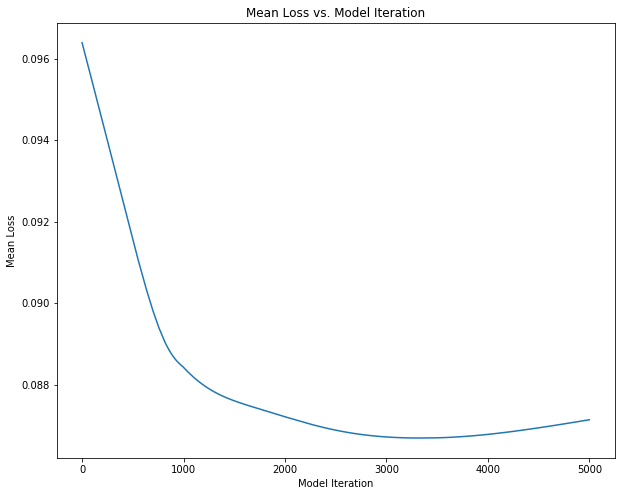

In [49]:
model = ForwardStagewiseGLM(link=LogitLink(),
                            loss=LogLoss(),
                            alpha=2.0,
                            weights="newton")
model.fit(X, y, iterations=5000)

# plot loss to make sure it is decreasing
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.plot(model._loss_list)
ax.set_title("Mean Loss vs. Model Iteration")
ax.set_xlabel("Model Iteration")
ax.set_ylabel("Mean Loss");

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
4999,0.0,0.0,0.584226,0.0,0.0,0.0,0.0,0.0,0.0,0.010994,...,0.0,0.0,0.0,0.0,0.642361,0.0,0.0,0.0,0.0,0.072466


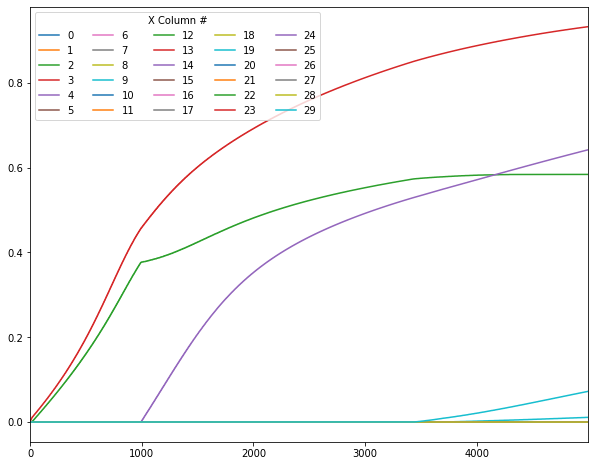

In [50]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
coef_history = pd.DataFrame(model.get_coefficient_history())
coef_history.plot(ax=ax)
ax.legend(title="X Column #", loc="best", ncol=5)
coef_history.tail(1)

In [51]:
model.get_coefficient_order()

[13, 2, 24, 29, 9]

### Test 2: Same as Test 1 but with CLogLogLink

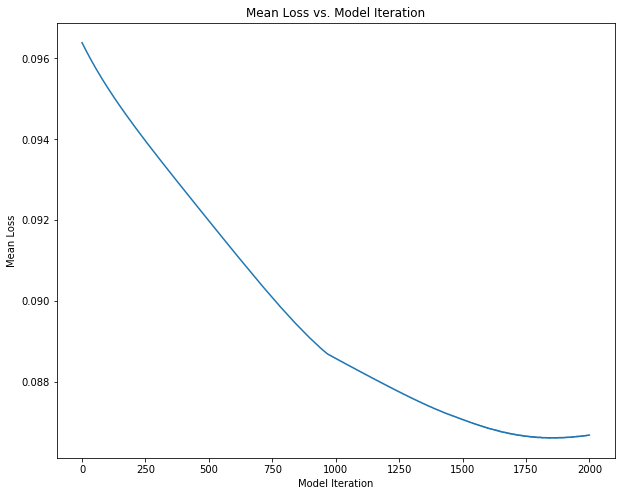

In [66]:
model = ForwardStagewiseGLM(link=CLogLogLink(),
                            loss=LogLoss(),
                            alpha=5.0,
                            weights="newton")
model.fit(X, y, iterations=2000)

# plot loss to make sure it is decreasing
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.plot(model._loss_list)
ax.set_title("Mean Loss vs. Model Iteration")
ax.set_xlabel("Model Iteration")
ax.set_ylabel("Mean Loss");

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
1999,0.0,0.0,0.392793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.449963,0.0,0.0,0.0,0.0,0.0


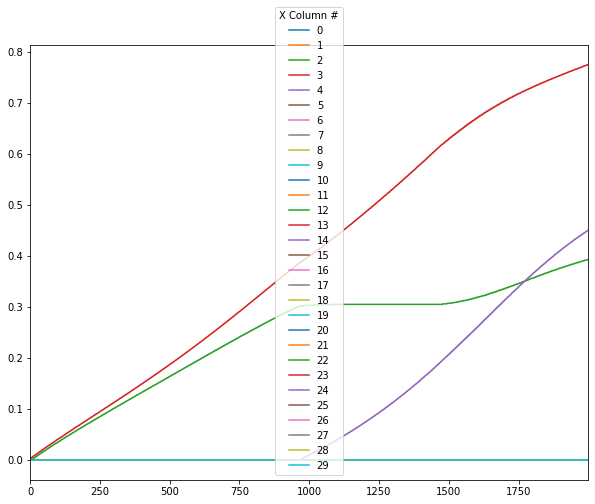

In [67]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
coef_history = pd.DataFrame(model.get_coefficient_history())
coef_history.plot(ax=ax)
ax.legend(title="X Column #")
coef_history.tail(1)

In [68]:
model.get_coefficient_order()

[13, 2, 24]